In [ ]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
from sklearn.metrics import accuracy_score ,classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download tawsifurrahman/covid19-radiography-database

covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip covid19-radiography-database.zip

Archive:  covid19-radiography-database.zip
replace COVID-19_Radiography_Dataset/COVID.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Data Preprocessing**

In [ ]:
covid=glob.glob('COVID-19_Radiography_Dataset/COVID/images/*.png', recursive = True)
lung_opacity=glob.glob('COVID-19_Radiography_Dataset/Lung_Opacity/images/*.png', recursive = True)
normal=glob.glob('COVID-19_Radiography_Dataset/Normal/images/*.png', recursive = True)
viral_pneumonia=glob.glob('COVID-19_Radiography_Dataset/Viral Pneumonia/images/*.png', recursive = True)
print("Number of covid labelled images = ",len(covid))
print("Number of lung opacity labelled images = ",len(lung_opacity))
print("Number of viral pneumonia labelled images = ",len(viral_pneumonia))
print("Number of normal labelled images = ",len(normal))

Number of covid labelled images =  3616
Number of lung opacity labelled images =  6012
Number of viral pneumonia labelled images =  1345
Number of normal labelled images =  10192


Thus, we see that the classes are unbalanced.

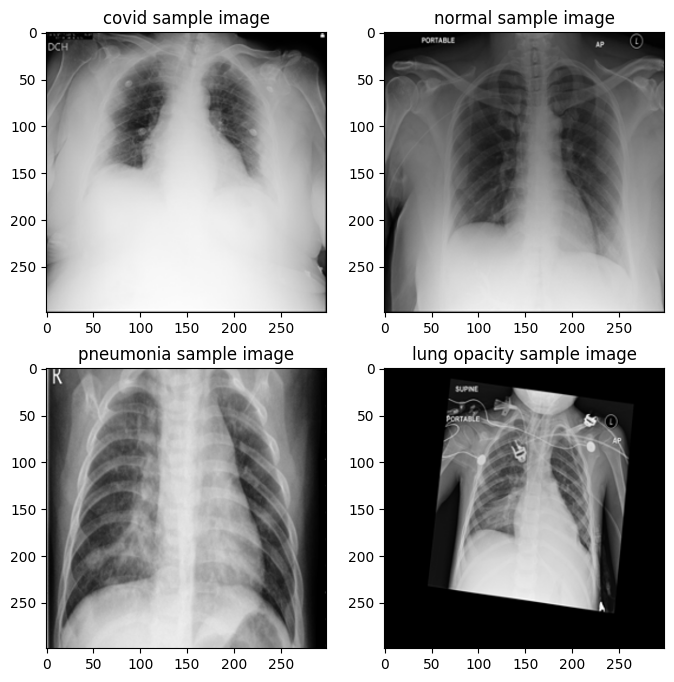

In [ ]:
figure,ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].set_title("covid sample image")
ax[0,0].imshow(cv2.imread(covid[0]))
ax[0,1].set_title("normal sample image")
ax[0,1].imshow(cv2.imread(normal[0]))
ax[1,0].set_title("pneumonia sample image")
ax[1,0].imshow(cv2.imread(viral_pneumonia[0])) 
ax[1,1].set_title("lung opacity sample image")
ax[1,1].imshow(cv2.imread(lung_opacity[0]))
plt.show()

Converting images to grayscale:

In [ ]:
covid_images=[]
normal_images=[]
viral_pneumonia_images=[]
lung_opacity_images=[]
for i in covid:
  img=cv2.imread(i)
  img_grayscale=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  covid_images.append(img_grayscale)
for i in normal:
  img=cv2.imread(i)
  img_grayscale=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  normal_images.append(img_grayscale)
for i in viral_pneumonia:
  img=cv2.imread(i)
  img_grayscale=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  viral_pneumonia_images.append(img_grayscale)
for i in lung_opacity:
  img=cv2.imread(i)
  img_grayscale=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  lung_opacity_images.append(img_grayscale)

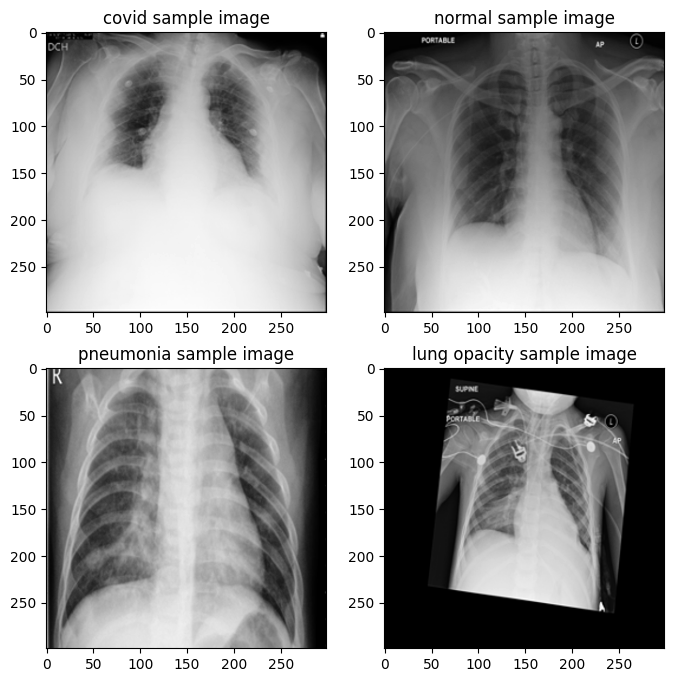

In [ ]:
figure,ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].set_title("covid sample image")
ax[0,0].imshow(covid_images[0],cmap='gray')
ax[0,1].set_title("normal sample image")
ax[0,1].imshow(normal_images[0],cmap='gray')
ax[1,0].set_title("pneumonia sample image")
ax[1,0].imshow(viral_pneumonia_images[0],cmap='gray')
ax[1,1].set_title("lung opacity sample image")
ax[1,1].imshow(lung_opacity_images[0],cmap='gray')
plt.show()

Creating tensors for images

In [ ]:
def resizing(img,sz=227):
    new_array = cv2.resize(img, (sz,sz))
    return new_array.reshape(-1, sz , sz, 1)

In [ ]:
def createtensor(img,s=227):
  return np.squeeze(np.array([resizing(i,s) for i in img])[:,:,:,:])

In [ ]:
covid_img=createtensor(covid_images)
np.save('/content/Covid_Data',covid_img)
covid_image_data=np.load('/content/Covid_Data.npy')
normal_img=createtensor(normal_images)
np.save('/content/Normal_Data',normal_img)
normal_image_data=np.load('/content/Normal_Data.npy')

Target variable is 1 if covid is detected otherwise 0

In [ ]:
bin_features = np.concatenate((covid_image_data, normal_image_data), axis=0)
np.save('/content/Bin_Features',bin_features)
bin_features=np.load('/content/Bin_Features.npy')
bin_y = np.concatenate((np.ones(covid_image_data.shape[0]),np.zeros(normal_image_data.shape[0])))
np.save('/content/Bin_y',bin_y)
bin_y=np.load('/content/Bin_y.npy')
bin_features = bin_features/227
bin_features = bin_features.astype(np.float32)    


Splitting data into Train-Test-Validation

Reference: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

In [ ]:
train_ratio = 0.70
validation_ratio = 0.12
test_ratio = 0.18
x_train, x_test, y_train, y_test = train_test_split(bin_features, bin_y, test_size=1 - train_ratio)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [ ]:
x_train = x_train.reshape(-1,227,227,1)
print(x_train.shape)
x_test = x_test.reshape(-1,227,227,1)
x_val = x_val.reshape(-1,227,227,1)
y_train = y_train.reshape(-1,1)
print(y_train.shape)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
np.save('/content/x_train',x_train)
x_train=np.load('/content/x_train.npy')
np.save('/content/x_test',x_test)
x_test=np.load('/content/x_test.npy')
np.save('/content/x_val',x_val)
x_val=np.load('/content/x_val.npy')
np.save('/content/y_train',y_train)
y_train=np.load('/content/y_train.npy')
np.save('/content/y_val',y_val)
y_val=np.load('/content/y_val.npy')
np.save('/content/y_test',y_test)
y_test=np.load('/content/y_test.npy')

**CNN for Binary Classification**

Reference: https://journals.physiology.org/doi/pdf/10.1152/physiolgenomics.00084.2020 

In [ ]:
inputs = Input(shape=(227, 227, 1))
x = Conv2D(96, kernel_size=(7, 7), use_bias=True, strides=(4, 4),
           padding='valid', activation='relu')(inputs)
x = LayerNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
x = Conv2D(256, kernel_size=(5, 5), use_bias=True, strides=(1, 1),
           groups=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss= keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])
print("No of layers in the model= ",len(model.layers))
model.summary()

In [ ]:
history = model.fit(x_train,y_train,steps_per_epoch=100 ,epochs=20,batch_size=32,validation_data=(x_val,y_val) , callbacks=[history])
print("Training accuracy: ",round(np.mean(history.history['accuracy'])*100,2))
print("Validation accuracy: ",round(np.mean(history.history['val_accuracy'])*100,2))

Predictions for test data:

In [ ]:
y_predicted=np.round(model.predict(x_test))

**Results**

In [ ]:
acc=round(accuracy_score(y_test,y_predicted)*100,2)
f1_score=round(f1_score(y_test,y_predicted),2)
roc_auc_score=round(roc_auc_score(y_test,y_predicted),2)
print("Accuracy is: ",acc)
print("F1 score is: ",f1_score)
print("ROC AUC score is: ",roc_auc_score)

Classification report:

In [ ]:
print(classification_report(y_test,y_predicted))